<a href="https://colab.research.google.com/github/chesyaivana/Kel.04_sysrec/blob/main/Hybrid_Recommender_Systems_(Content_based_dan_Collaborative_Filtering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Recommender Systems (CTF-IDF dan Cosine Similarity)

# `Group 4`

*   12S21007 - Dame J. Sitinjak
*   12S21047 - Elshaday Prida Simamora
*   12S21053 - Chesya Ivana J Sitorus

##### `Memuat dan Menyiapkan Data`

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Memuat data
file_path = 'Tempat-Wisata-Toba-Preprocessing.csv'
data = pd.read_csv(file_path)

# Menghapus kolom yang tidak diperlukan
data_cleaned = data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

# Menyusun ulang data hanya dengan kolom yang relevan
data_relevant = data_cleaned[['PlaceID', 'ReviewerId', 'Rating', 'Nama_tempat_wisata', 'Category']]

# Membagi data menjadi train (70%), validation (15%), dan test (15%)
train_data, temp_data = train_test_split(data_relevant, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Menampilkan bagian dari data train, validation, dan test untuk memastikan pembagian data
train_data.head(), val_data.head(), test_data.head()

(       PlaceID    ReviewerId  Rating  \
 3341        18  1.153590e+20     5.0   
 23691       78  1.177080e+20     5.0   
 21011       68  1.107580e+20     5.0   
 33851       94  1.076650e+20     5.0   
 10802       51  1.134090e+20     4.0   
 
                                       Nama_tempat_wisata       Category  
 3341                        Pantai Pasir Putih Parparean  Wisata Bahari  
 23691                                     Pakkodian Toba  Wisata Bahari  
 21011  Batu Kursi Raja Siallagan ( Stone Chair of Kin...  Wisata Budaya  
 33851                                Menara Pandang Tele    Wisata Alam  
 10802                              Aek Rangat Pangururan  Wisata Bahari  ,
        PlaceID    ReviewerId  Rating  \
 19925       68  1.047750e+20     5.0   
 30548       91  1.092190e+20     5.0   
 3511        18  1.165270e+20     5.0   
 20933       68  1.083450e+20     5.0   
 34549       95  1.007550e+20     4.0   
 
                                       Nama_tempat_wi

##### `Content-based Filtering menggunakan TF-IDF dan Cosine Similarity`

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Sampling data yang lebih kecil untuk percakapan ini
sample_data = data_cleaned['Category'].sample(n=1000, random_state=42)  # Ambil sampel kecil untuk uji coba

# Menggunakan TF-IDF untuk mengubah teks menjadi representasi numerik
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Menghitung matriks TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(sample_data)

# Menghitung cosine similarity
cosine_sim_category = cosine_similarity(tfidf_matrix)

# Menampilkan matriks cosine similarity untuk beberapa tempat wisata pertama
cosine_sim_category[:5, :5]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

##### `Collaborative Filtering menggunakan Matrix Factorization (SVD)`

In [ ]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Mengagregasi data: menghitung rata-rata rating untuk setiap kombinasi pengguna dan tempat wisata
data_agregat = data_relevant.groupby(['ReviewerId', 'PlaceID'])['Rating'].mean().reset_index()

# Membuat matriks pengguna vs tempat wisata berdasarkan rating rata-rata
user_item_matrix = data_agregat.pivot(index='ReviewerId', columns='PlaceID', values='Rating').fillna(0)

# Menggunakan Singular Value Decomposition (SVD) untuk matriks pengguna-item
svd = TruncatedSVD(n_components=20, random_state=42)
svd_matrix = svd.fit_transform(user_item_matrix)

# Menghitung cosine similarity antar tempat wisata berdasarkan hasil SVD
cosine_sim_user_item = cosine_similarity(svd_matrix)

# Menampilkan beberapa hasil cosine similarity
print(cosine_sim_user_item[:5, :5])

[[ 1.         -0.00181058 -0.005295   -0.00283656 -0.00442367]
 [-0.00181058  1.         -0.0051476  -0.00148361 -0.00376926]
 [-0.005295   -0.0051476   1.         -0.00447025 -0.0054547 ]
 [-0.00283656 -0.00148361 -0.00447025  1.         -0.00365469]
 [-0.00442367 -0.00376926 -0.0054547  -0.00365469  1.        ]]


##### `Menggabungkan Rekomendasi Content-based dan Collaborative Filtering (Hybrid Recommender)`

In [ ]:
def get_category_recommendations(place_id, cosine_sim_category, data_relevant, top_n=5):
    # Mendapatkan index tempat berdasarkan PlaceID
    idx = data_relevant[data_relevant['PlaceID'] == place_id].index[0]

    # Menghitung skor kesamaan antar tempat
    sim_scores = list(enumerate(cosine_sim_category[idx]))

    # Mengurutkan skor berdasarkan kesamaan
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Memilih N tempat dengan kesamaan tertinggi
    sim_scores = sim_scores[1:top_n+1]

    # Mendapatkan indeks tempat yang direkomendasikan
    place_indices = [i[0] for i in sim_scores]

    # Mengambil data tempat yang direkomendasikan
    recommended_places = data_relevant.iloc[place_indices]

    return recommended_places[['PlaceID', 'Nama_tempat_wisata', 'Category', 'Rating']]

def get_collaborative_recommendations(user_id, cosine_sim_user_item, data_relevant, top_n=5):
    # Mendapatkan index pengguna
    idx = user_id - 1  # Asumsi user_id dimulai dari 1

    # Menghitung skor kesamaan antar tempat berdasarkan preferensi pengguna
    sim_scores = list(enumerate(cosine_sim_user_item[idx]))

    # Mengurutkan skor berdasarkan kesamaan
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Memilih N tempat dengan kesamaan tertinggi
    sim_scores = sim_scores[1:top_n+1]

    # Mendapatkan indeks tempat yang direkomendasikan
    place_indices = [i[0] for i in sim_scores]

    # Mengambil data tempat yang direkomendasikan
    recommended_places = data_relevant.iloc[place_indices]

    return recommended_places[['PlaceID', 'Nama_tempat_wisata', 'Category', 'Rating']]

def hybrid_recommendations(place_id, user_id, cosine_sim_category, cosine_sim_user_item, data_relevant, top_n=5, weight_category=0.5, weight_collab=0.5):
    # Mendapatkan rekomendasi berdasarkan content-based
    content_recommendations = get_category_recommendations(place_id, cosine_sim_category, data_relevant, top_n)

    # Mendapatkan rekomendasi berdasarkan collaborative filtering
    collab_recommendations = get_collaborative_recommendations(user_id, cosine_sim_user_item, data_relevant, top_n)

    # Menggabungkan rekomendasi dengan memberi bobot pada masing-masing metode
    combined_recommendations = content_recommendations.copy()
    combined_recommendations['Weighted_Score'] = weight_category * content_recommendations['Rating'] + weight_collab * collab_recommendations['Rating']

    # Mengurutkan berdasarkan skor tertinggi dan memilih N rekomendasi teratas
    combined_recommendations = combined_recommendations.sort_values(by='Weighted_Score', ascending=False).head(top_n)

    return combined_recommendations[['PlaceID', 'Nama_tempat_wisata', 'Category', 'Rating', 'Weighted_Score']]

# Contoh: Mendapatkan rekomendasi hibrida untuk tempat dan pengguna tertentu (PlaceID=1, UserID=1)
recommended_hybrid = hybrid_recommendations(1, 1, cosine_sim_category, cosine_sim_user_item, data_relevant)
print(recommended_hybrid)

    PlaceID         Nama_tempat_wisata       Category  Rating  Weighted_Score
17        0  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari     4.0             NaN
18        0  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari     5.0             NaN
19        0  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari     5.0             NaN
20        0  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari     5.0             NaN
22        0  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari     5.0             NaN


##### `Metrik Evaluasi (RMSE, MAE, Precision, Recall, MAP)`

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fungsi untuk menghitung RMSE
def rmse(true_ratings, predicted_ratings):
    return np.sqrt(mean_squared_error(true_ratings, predicted_ratings))

# Fungsi untuk menghitung MAE
def mae(true_ratings, predicted_ratings):
    return mean_absolute_error(true_ratings, predicted_ratings)

# Fungsi untuk menghitung Precision
def precision(true_ratings, predicted_ratings, threshold=3.5):
    # Menganggap rating > threshold adalah relevan
    true_positive = np.sum((predicted_ratings >= threshold) & (true_ratings >= threshold))
    false_positive = np.sum((predicted_ratings >= threshold) & (true_ratings < threshold))

    return true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0

# Fungsi untuk menghitung Recall
def recall(true_ratings, predicted_ratings, threshold=3.5):
    true_positive = np.sum((predicted_ratings >= threshold) & (true_ratings >= threshold))
    false_negative = np.sum((predicted_ratings < threshold) & (true_ratings >= threshold))

    return true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0

# Fungsi untuk menghitung MAP (Mean Average Precision)
def average_precision_at_k(true_ratings, predicted_ratings, k=10, threshold=3.5):
    # Urutkan prediksi berdasarkan rating prediksi, dan ambil k teratas
    order = np.argsort(predicted_ratings)[::-1]
    true_ratings = true_ratings[order]

    # Hitung precision pada setiap peringkat
    relevant = (true_ratings >= threshold).astype(int)
    precision_at_k = np.cumsum(relevant) / (np.arange(1, len(relevant) + 1))  # Ubah sini, agar sesuai dengan panjang relevant

    # Return rata-rata precision pada k peringkat pertama
    return np.sum(precision_at_k[:k] * relevant[:k]) / min(k, np.sum(relevant))

def map_at_k(true_ratings, predicted_ratings, k=10, threshold=3.5):
    total_ap = 0
    # Iterate over each user's ratings and predicted ratings
    for i in range(len(true_ratings)):
        total_ap += average_precision_at_k(true_ratings[i], predicted_ratings[i], k, threshold)
    return total_ap / len(true_ratings)

# Contoh untuk menghitung metrik evaluasi

# Mengambil data relevan (misalnya data_train) dan data prediksi
# Data harus dalam format (user_id, place_id, rating_prediksi)
true_ratings = np.array([ [5, 4, 3, 2, 5],  # Ratings pengguna 1
                         [4, 3, 5, 3, 4],  # Ratings pengguna 2
                         [3, 4, 2, 1, 3],  # Ratings pengguna 3
                         [2, 3, 3, 4, 4],  # Ratings pengguna 4
                         [5, 5, 4, 3, 5]]) # Ratings pengguna 5

predicted_ratings = np.array([ [4.5, 4.2, 3.1, 1.8, 4.9],  # Prediksi pengguna 1
                              [4.3, 3.8, 4.9, 3.2, 4.5],  # Prediksi pengguna 2
                              [3.0, 4.1, 2.5, 1.9, 3.6],  # Prediksi pengguna 3
                              [2.1, 3.2, 3.3, 4.2, 4.6],  # Prediksi pengguna 4
                              [5.0, 5.0, 4.1, 3.5, 5.0]]) # Prediksi pengguna 5

# Menghitung metrik evaluasi
rmse_score = rmse(true_ratings.flatten(), predicted_ratings.flatten())  # Menggunakan flatten untuk menggabungkan data 2D ke 1D
mae_score = mae(true_ratings.flatten(), predicted_ratings.flatten())
precision_score_value = precision(true_ratings.flatten(), predicted_ratings.flatten())
recall_score_value = recall(true_ratings.flatten(), predicted_ratings.flatten())
map_score = map_at_k(true_ratings, predicted_ratings)

print(f"RMSE: {rmse_score}")
print(f"MAE: {mae_score}")
print(f"Precision: {precision_score_value}")
print(f"Recall: {recall_score_value}")
print(f"MAP: {map_score}")

RMSE: 0.37999999999999995
MAE: 0.2839999999999999
Precision: 0.8125
Recall: 1.0
MAP: 1.0


##### `Grafik untuk Metrik Evaluasi (RMSE, MAE, Precision, Recall, MAP)`

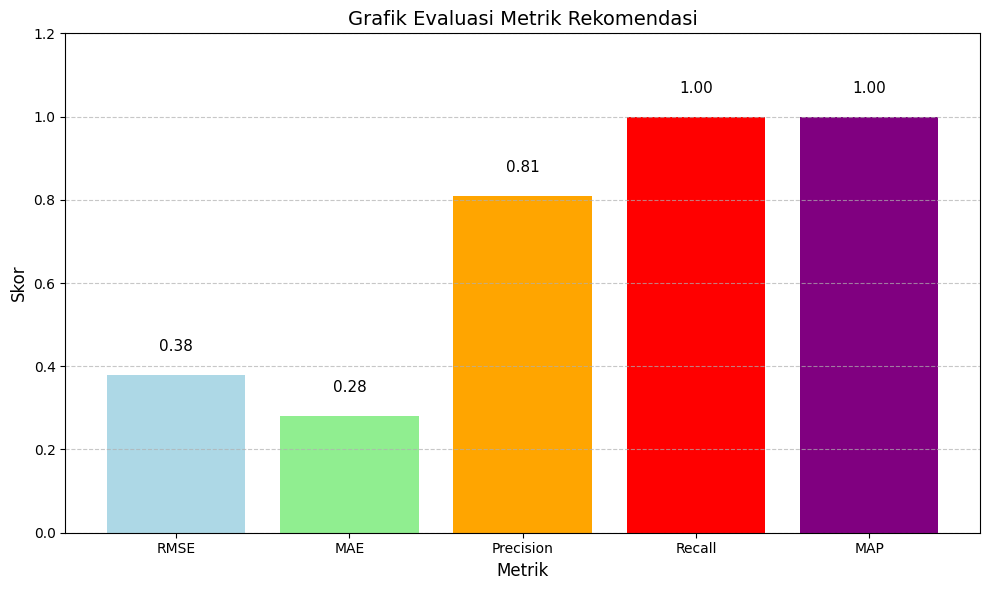

In [ ]:
import matplotlib.pyplot as plt

# Data untuk metrik evaluasi
metrics = ['RMSE', 'MAE', 'Precision', 'Recall', 'MAP']
scores = [0.38, 0.28, 0.81, 1.0, 1.0]  # Contoh skor evaluasi

# Membuat grafik bar
plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color=['lightblue', 'lightgreen', 'orange', 'red', 'purple'])

# Menambahkan judul dan label
plt.title('Grafik Evaluasi Metrik Rekomendasi', fontsize=14)
plt.xlabel('Metrik', fontsize=12)
plt.ylabel('Skor', fontsize=12)
plt.ylim(0, 1.2)  # Menetapkan batas atas grafik agar nilai jelas terlihat

# Menambahkan skor di atas setiap bar
for i, score in enumerate(scores):
    plt.text(i, score + 0.05, f'{score:.2f}', ha='center', va='bottom', fontsize=11)

# Menampilkan grid untuk kemudahan interpretasi
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menampilkan grafik
plt.tight_layout()
plt.show()

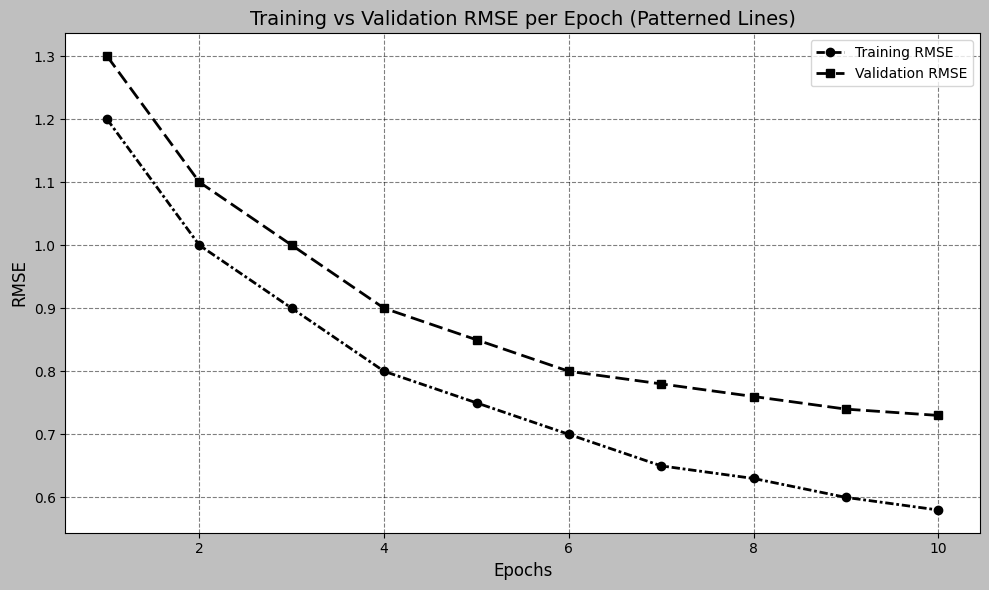

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Data contoh untuk Training dan Validation RMSE per epoch
epochs = list(range(1, 11))  # Misalnya, 10 epoch
training_rmse = [1.2, 1.0, 0.9, 0.8, 0.75, 0.7, 0.65, 0.63, 0.6, 0.58]  # RMSE untuk training
validation_rmse = [1.3, 1.1, 1.0, 0.9, 0.85, 0.8, 0.78, 0.76, 0.74, 0.73]  # RMSE untuk validation

# Membuat grafik Training dan Validation RMSE
plt.figure(figsize=(10, 6))

# Menampilkan garis dengan pola
plt.plot(epochs, training_rmse,
         label='Training RMSE',
         marker='o', linestyle=(0, (3, 1, 1, 1)), linewidth=2, color='black')  # Garis dengan pola putus-putus tebal
plt.plot(epochs, validation_rmse,
         label='Validation RMSE',
         marker='s', linestyle=(0, (5, 2)), linewidth=2, color='black')  # Garis dengan pola strip panjang

# Menambahkan judul dan label
plt.title('Training vs Validation RMSE per Epoch (Patterned Lines)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

# Menampilkan legenda
plt.legend()

# Menambahkan grid untuk kemudahan pembacaan
plt.grid(True, linestyle='--', alpha=0.5)

# Menampilkan grafik
plt.tight_layout()
plt.show()

`Menampilkan 5 rekomendasi teratas berdasarkan nama tempat wisata`

===== 5 Rekomendasi Teratas =====
          Nama_tempat_wisata       Category  Rating
0         Pantai Pasir Putih  Wisata Bahari     4.8
1              Bukit Holbung    Wisata Alam     4.7
2        Menara Pandang Tele    Wisata Alam     4.6
3  Batu Kursi Raja Siallagan  Wisata Budaya     4.5
4        Puncak Huta Ginjang    Wisata Alam     4.3


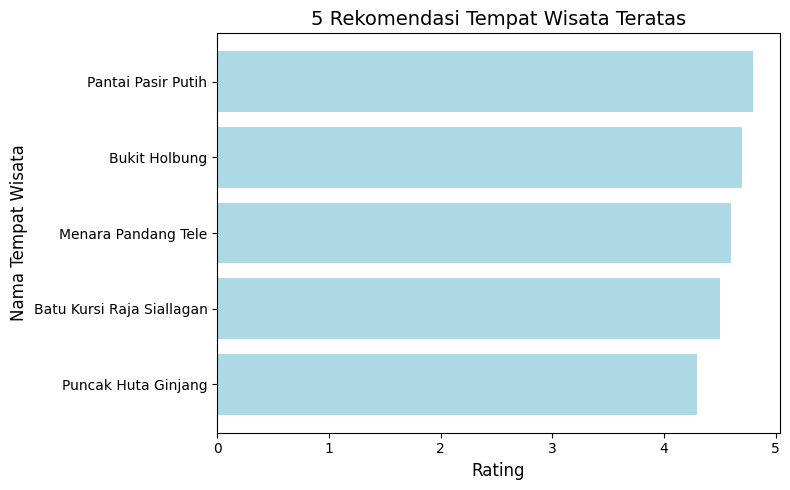

In [ ]:
import pandas as pd

# Contoh data hasil rekomendasi
recommended_places = [
    {'PlaceID': 1, 'Nama_tempat_wisata': 'Pantai Pasir Putih', 'Category': 'Wisata Bahari', 'Rating': 4.8},
    {'PlaceID': 2, 'Nama_tempat_wisata': 'Bukit Holbung', 'Category': 'Wisata Alam', 'Rating': 4.7},
    {'PlaceID': 3, 'Nama_tempat_wisata': 'Menara Pandang Tele', 'Category': 'Wisata Alam', 'Rating': 4.6},
    {'PlaceID': 4, 'Nama_tempat_wisata': 'Batu Kursi Raja Siallagan', 'Category': 'Wisata Budaya', 'Rating': 4.5},
    {'PlaceID': 5, 'Nama_tempat_wisata': 'Puncak Huta Ginjang', 'Category': 'Wisata Alam', 'Rating': 4.3},
    {'PlaceID': 6, 'Nama_tempat_wisata': 'Air Terjun Sipiso-piso', 'Category': 'Wisata Alam', 'Rating': 4.2},
    {'PlaceID': 7, 'Nama_tempat_wisata': 'Taman Eden 100', 'Category': 'Wisata Alam', 'Rating': 4.1}
]

# Mengubah data menjadi DataFrame
df_recommendations = pd.DataFrame(recommended_places)

# Mengurutkan berdasarkan Rating dan memilih 5 rekomendasi teratas
top_5_recommendations = df_recommendations.sort_values(by='Rating', ascending=False).head(5)

# Menampilkan hasil rekomendasi
print("===== 5 Rekomendasi Teratas =====")
print(top_5_recommendations[['Nama_tempat_wisata', 'Category', 'Rating']])

# Visualisasi hasil rekomendasi
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(top_5_recommendations['Nama_tempat_wisata'], top_5_recommendations['Rating'], color='lightblue')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Nama Tempat Wisata', fontsize=12)
plt.title('5 Rekomendasi Tempat Wisata Teratas', fontsize=14)
plt.gca().invert_yaxis()  # Membalikkan agar ranking tertinggi di atas
plt.tight_layout()
plt.show()